In [1]:
from typing import Literal
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

from fddbenchmark.dataset import FDDDataset

In [2]:
dataset = FDDDataset(name='small_tep')

Reading data/small_tep/labels.csv: 100%|███| 153300/153300 [00:00<00:00, 4747216.98it/s]
Reading data/small_tep/train_mask.csv: 100%|█| 153300/153300 [00:00<00:00, 4487436.34it/
Reading data/small_tep/test_mask.csv: 100%|█| 153300/153300 [00:00<00:00, 4597688.98it/s


In [3]:
def concat_sliding_window_features(df: pd.DataFrame, window_size: int, dilation: int, fill_nans: bool = True) -> pd.DataFrame:
    df = df.reset_index()
    new_df = df.copy()
    for shift in range(1, window_size, dilation):
        if shift == 1:
            suffix = '_1_step_before'
        else:
            suffix = f'_{shift}_steps_before'

        shifted = df.shift(shift)
        shifted[shifted.run_id != df.run_id] = np.nan
        shifted.drop(['run_id', 'sample'], axis=1, inplace=True)
        new_df = pd.concat([new_df, shifted.add_suffix(suffix)], axis=1)

    new_df.set_index(['run_id', 'sample'], inplace=True)

    if fill_nans:
        new_df.fillna(method='bfill', inplace=True)

    return new_df

In [40]:
df = concat_sliding_window_features(dataset.df, 100, 5)

In [41]:
df.shape

(153300, 1092)

In [42]:
X_train = df[dataset.train_mask].values
y_train = dataset.labels[dataset.train_mask].values

In [43]:
len(X_train)

52500

In [44]:
X_train = X_train[y_train == 0]

In [45]:
len(X_train)

4500

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [47]:
pca = PCA(n_components=500)
pca.fit(X_train)

PCA(n_components=500)

<Axes: >

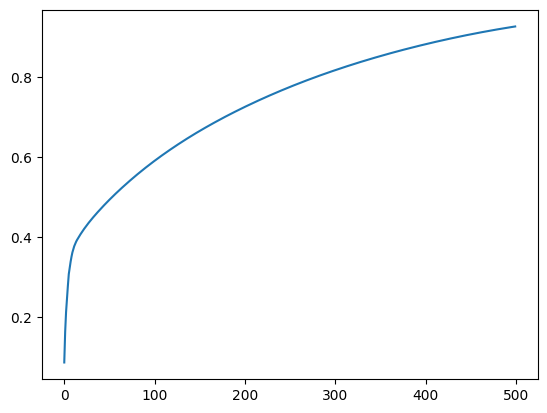

In [48]:
sns.lineplot(np.cumsum(pca.explained_variance_ratio_))

In [49]:
# pca = PCA(n_components=70)
X_train_pca = pca.transform(X_train)

In [50]:
X_test = df[dataset.test_mask].values
y_test = dataset.labels[dataset.test_mask].values

In [51]:
X_test = scaler.transform(X_test)

In [52]:
X_test_pca = pca.transform(X_test)

In [53]:
y_pred_t2 = np.sum(X_test_pca ** 2 / pca.explained_variance_, axis=1)

In [54]:
y_pred_spe = np.linalg.norm(pca.inverse_transform(X_test_pca) - X_test, axis=1)

In [55]:
roc_auc_score(y_test != 0, y_pred_spe)

0.9545046778846155

In [56]:
roc_auc_score(y_test != 0, y_pred_t2)

0.9239739507211538